In [1]:
!git clone https://github.com/iuryzanonni/te-machine-learning
!cd te-machine-learning/ap-de-maquina-cefetmg-felicia-master && mv * /content/

Cloning into 'te-machine-learning'...
remote: Enumerating objects: 4176, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4176 (delta 26), reused 31 (delta 11), pack-reused 4119
Receiving objects: 100% (4176/4176), 180.63 MiB | 36.64 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (4115/4115), done.


Esta prática foi baseada no Capítulo 4 do livro "Deep Learning with Python" (Chollet F., 2017). Nela iremos estudar arquiteturas de Redes Neurais Profundas para identificar gatos e cachorros em fotos. Esse dataset foi uma amostra extraida do [desafio do Kaggle](colab.research.google.com). O objetivo desta prática é:
- demonstrar como é possível usar Redes Neurais Convolucionarias (CNN)  mesmo em um dataset pequeno;
- conhecer o framework Keras;
- apresentar, por meio de mini-batches, como usar de forma eficiente a memória quando possuimos um dataset com milhares de atributos e, consequentemente, consumiria muita memória principal;
- demonstrar a vantagem da CNN ao comparar  com uma Rede Neural Totalmente Conectada (FC, do inglês _Fully Connected Network_) quando a entrada é uma imagem.





A limitação dessa prática é que assumimos que a imagem corresponde a apenas um animal (ou vários sendo apenas cachorros ou apenas gatos). Em um problema maior, deveriamos identificar objetos na imagem, para, logo após, realizarmos cortes na imagem e classificamos cada objeto identificado.

Esta prática não possui testes unitários mas, para cada atividade, apresento que é esperado da mesma (ou como testar seu funcionamento).

**Para entregar: ** Caso você tenha usado o google colab para algo, coloque o link. Elimine as imagens do dataset e os arquivos de modelos treinados (.h5). Não esqueça de executar todas os códigos para que eu consiga avaliar todas as saídas - não será considerado código que não foi executado e salvo a saída da execução no Jupyter.

## Configuração da prática

Primeiramente, você deverá instalar o Keras e o TensorFlow:

*pip3* install keras, tensorflow, pydot

Notei que em alguns computadores que não possuem GPU, deve-se instalar o `tensorflow-cpu` ao invés do tensorflow

In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 71.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

In [2]:
from cats_vs_dogs import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img
from keras import Model
from keras import layers
from keras import Input

import math

Veja a inicialização da classe `Constantes` e da `ParametrosRedeNeural` no arquivo `cats_vs_dogs.py`. Você precisará desses valores ao longo da prática. Veja que lá, passamos o tipo de otimização usando classes do módulo [optimizers](https://keras.io/optimizers/) do Keras. Dentro desse objeto que definimos a taxa de aprendizado. No otimizador RMSProp, o parametro $\beta$ que usamos na nossa aula teórica é o parâmetro `rho` da inicialização da classe `RMSProp`.

## Notação utilizada

- $m$: quantidade de instâncias;
- $t$: tamanho do mini-batch;
- $w$: largura da imagem. Toda imagem possuirá o mesmo tamanho;
- $h$: altura da imagem;
- $c$: número de canais da imagem (ex. 1 canal: escala de cinzas; 3 canais: vermelho, verde e azul);
- $X$: Matriz de instâncias representadas pelos pixels das imagens. A ordem da matriz é $t \times h \times w \times c$;
- $\pmb{y}$: Vetor de tamanho $m$ representando a classe real de cada instância;
- $\pmb{\hat{y}}$: Vetor de predições que, para cada instancia, possui o valor predito para ela. Caso seja uma classificação binária, este valor será 0 ou 1.

## Obtenção do Dataset utilizando Batches e DataGenerator

Iremos usar um dataset de 4096 fotos de cachorros e gatos em que são 2048 fotos de cachorros e 2048 fotos de gato. Ele foi dividido de forma balanceada e aleatória em treino (2048 instancias), validação (1024 instâncias) e teste (1024 instâncias). Esse dataset está [disponivel no GitHub](https://github.com/daniel-hasan/cats-vs-dogs/archive/master.zip). Efetue o download, armazene no diretório `data` para fazer as tarefas.

Ao trabalharmos milhares/milhões de imagens, nos deparamos com um problema: não conseguimos armazenar todas elas em memória principal. Por isso, a utilização do mini-batch gradient decent é importante, junto com os algoritmos de otimização que aprendemos (Gradiente Descent with Momentum, RMSProp e Adam).

O Keras possui a classe [ImageGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) para preprocessar imagens,  trabalhar com mini-batches de imagens e fazer, inclusive, _Data Augmentation_.  Na primeira parte desta prática iremos utilizá-la apenas para facilitar o uso de mini-batches e realizar o preprocessamento. Mais especificamente, iremos usar o método [flow_from_data_dir](https://keras.io/preprocessing/image/#flow_from_directory) que recebe como entrada uma estrutura de diretórios similar a esta:

<img src="https://github.com/daniel-hasan/ap-de-maquina-cefetmg-felicia/blob/master/imgs/dataset-generator.png?raw=1">

Nessa estrutura, cada subdiretório será uma classe com todas as imagens referentes a ela. `flow_from_data_dir` retorna um objeto iterável que, em cada iteração, retornará a tupla $(X,\pmb{y})$, ou seja, um mini-batch $X$ e o vetor de classe $\pmb{y}$ de cada instancia retornada pelo mini-batch (ver notação utilizada). Dessa forma, esse método armazena em memória principal apenas $t$ imagens por vez, ao invés do dataset completo.  

O `flow_from_data_dir` retorna um iterador que entraria em um loop infinito: após iterar sobre todas as imagens, ele faz a operação toda novamente. Por isso, caso desejarmos navegar em todas as imagens por um `for`, temos que definir um ponto de parada que, sem _data augmentation_, é o número de imagens.

**Atividade 1 - Hello World DataGenerator:** crie uma pasta `img_toy_test` baseando-se estrutura acima com duas classes. Na primeira, coloque três cachorrinhos e, na outra, três gatinhos de sua escolha. Complete o código da função `plot_imgs_from_iterator` para efetuar a exibição dos mesmos. Essa função não possui teste unitário.  

Found 6 images belonging to 2 classes.
x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


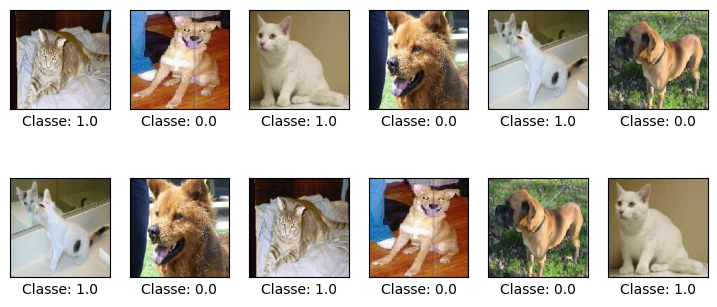

In [3]:
#No image generator, você usará apenas um parametro rescale
#..para deixar cada pixel entre 0 e 1.
#..Lembre-se que cada pixel originalmente é um valor entre 0 e 255
img_generator = ImageDataGenerator(rescale=1/255)

#ao fazer o iterador, você deverá definir:
#..O tamanho para que todas as imagens sejam redimensionadas;
#..O modo de classificação que será binário (caso contrario, a representação nao seria um vetor)
#..O seed sempre fixo de Constantes.SEED para permitirmos a reprodutibilidade dos experimentos
#..Escolha um tamanho do batch de 2
it_datagen = img_generator.flow_from_directory(
                                                       "img_toy_test",
                                                        target_size=(150,150),
                                                        batch_size=2,
                                                        class_mode='binary',
                                                        seed=2
                                                        )
plot_imgs_from_iterator(it_datagen,2,6)

Veja que o iterador passou duas vezes pelas imagens apresentando, aleatoriamente, cada uma das imagens. Verifique as dimensões (shape) dos elementos para entender como as imagens foram representadas. Apenas na apresentação, o tamanho da imagem apresentada pelo gnuplot é redimensionada proporcional ao valor passado na função figsize.

**Atividade 2 - função `get_dataset`:** Nosso dataset já foi dividido em 3 partições: treino, teste e validação. Entendendo o funcionamento do `ImageDataGenerator`, você deverá implementar a função `get_dataset` que retornará um vetor três iteradores um para o treino, outro para teste e outro para validação. Esse vetor de iteradores obedecerá a mesma ordem de `Constantes.ARR_STR_DATA_DIR`. Para testar, você pode fazer um treino, teste e validação cada um com 6 itens e testar usando o `plot_imgs_from_iterator`.

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


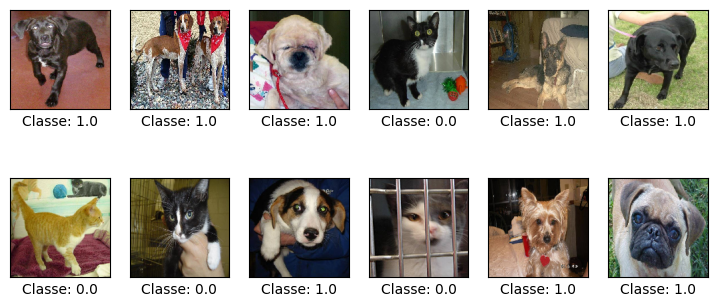

x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


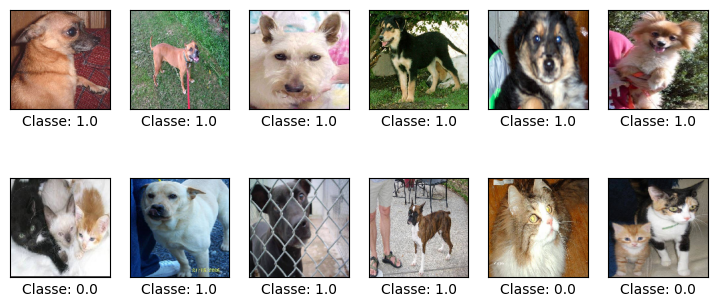

x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


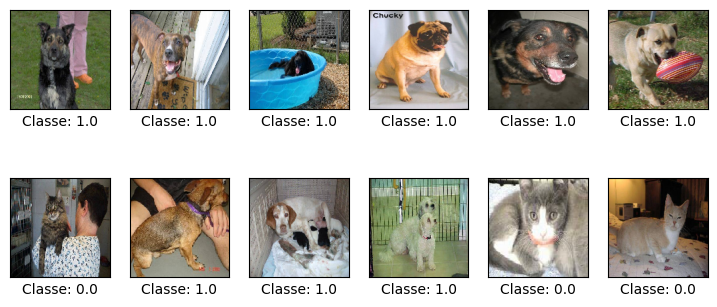

In [4]:
from cats_vs_dogs import *
#print(Constantes.ARR_STR_DATA_DIR)
particoes = get_dataset(ParametrosRedeNeural(int_batch_size=2),Constantes.ARR_STR_DATA_DIR)
#particoes = get_dataset(6,['/content/data/treino','/content/data/validacao','/content/data/teste'])
for particao in particoes:
  plot_imgs_from_iterator(particao,2,6)

## Criação dos modelos para identificar gatineos e cachorrineos

Como a execução dos modelos que iremos criar pode demorar uns 30 minutos, iremos, primeiramente criar cada modelo para, na próxima seção, executarmos e fazermos a análise. Sempre consideramos que a imagem possuirá as dimensões 150x150x3.

**Atividade 3 - Criação de uma Fully Connected Network (FC) usando Keras:** Inicialmente, iremos implementar uma Rede Neural Totalmente Conectada (sem uso de convoluções) por meio do Keras. Você deverá implementar a seguinte Rede Neural:

<img src="https://github.com/daniel-hasan/ap-de-maquina-cefetmg-felicia/blob/master/imgs/arquitetura-fc.png?raw=1">

Existem duas formas de implementar uma Rede Neural no Keras. Abaixo apresentamos o uso da [API funcional do Keras](https://keras.io/getting-started/functional-api-guide/) para uma arquetura similar aquela que você irá implementar. Existe outra API ([Sequential Model](https://keras.io/getting-started/sequential-model-guide/)), porém ela é menos flexivel. Perceba que aqui você irá criar o modelo/arquitetura mas ainda não irá realizar o treinamento.

In [5]:
#entrada (imagens de dimensões 150x150x3)
entrada = Input(shape=(150,150,3),name="Entrada")


achatar = layers.Flatten()(entrada)
#uma camada (ativação = relu) com 100 neuronios (unidades) a entrada (em formato de vetor) é passada como parametro
camada_um = layers.Dense(100,activation="relu",name="Camada1")(achatar)
camada_dois = layers.Dense(200,activation="relu",name="Camada2")(camada_um)
#camada de saida
#lembre-se que é uma classificação binária, a ativação é sigmoid
saida = layers.Dense(1,activation="sigmoid", name="saida")(camada_dois)

#cria-se o modelo
modelo = Model(inputs=entrada, outputs=saida)

Cada variável `camada_*` é uma camada. Veja que passamos uma camada como entrada da outra. [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) é uma FC, ou seja, umacamada totalmente conectada (pois, podemos chamá-la também de densely conected layers). Usamos uma camada [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) para "achatar"  a representação. Ou seja, cada instancia de imagem é representada por uma matriz 150x150x3 é transformada em um vetor de 67.500 atributos. Podemos ver a arquitetura usando `modelo.summary()`. Também podemos usar a função [plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model) para exibir a imagem da arquitetura também - para visualizar a imagem, é necessário instalar algumas dependencias.

In [6]:
modelo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 Camada1 (Dense)             (None, 100)               6750100   
                                                                 
 Camada2 (Dense)             (None, 200)               20200     
                                                                 
 saida (Dense)               (None, 1)                 201       
                                                                 
Total params: 6770501 (25.83 MB)
Trainable params: 6770501 (25.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Veja que, mesmo uma rede neural com pouca profundidade, temos milhões de parametros a serem aprendidos.

Agora, implemente a função `fully_connected_model` do arquivo `cats_vs_dogs.py` a seguinte rede neural totalmente conectada:

Execute a função abaixo e armazene o modelo em `model_fc`. O número esperado de parametros a serem aprendidos é de 33.870.901.

In [3]:
model_fc = fully_connected_model()
model_fc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 Camada1 (Dense)             (None, 500)               33750500  
                                                                 
 Camada2 (Dense)             (None, 200)               100200    
                                                                 
 Camada3 (Dense)             (None, 100)               20100     
                                                                 
 saida (Dense)               (None, 1)                 101       
                                                                 
Total params: 33870901 (129.21 MB)
Trainable params: 33870901

**Atividade 4 - criação de uma Rede Neural Convolucional:** Agora você implementará na função `simple_cnn_model` o modelo da seguinte rede convolucional usando o Keras:

<img src="https://github.com/daniel-hasan/ap-de-maquina-cefetmg-felicia/blob/master/imgs/arquitetura-cnn.png?raw=1">

Para isso, veja a seguir um exemplo das camadas de convolução e MaxPooling ([Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) e [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)):

In [8]:
entrada = Input(shape=(150,150,3),name="Entrada")
conv_2d_a = layers.Conv2D(32,(3,3),activation="relu",name="Convolucao1")(entrada)
max_polling_a = layers.MaxPool2D((2,2))(conv_2d_a)

Esse exemplo é a parte inicial da arquitetura que você deverá implementar. Não esqueça de
usar Flatten quando necessário. Logo após "achatar" a representação em um vetor, caso o parametro `add_dropout==True` você deverá usar o [Dropout](https://keras.io/layers/core/) em que 50% das ativações serão aleatoriamente zeradas. Abaixo, crie o modelo e armazene em `model_cnn_dropout` e  `model_cnn` as versões com e sem dropout, respectivamente. As duas arquiteturas possuirão 3.453.121 parametros a serem aprendidos.

In [4]:
from cats_vs_dogs import*
model_cnn = simple_cnn_model(add_dropout=False)
model_cnn_dropout = simple_cnn_model(add_dropout=True)

Exiba as arquiteturas das CNNs criadas

In [5]:
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 Convolucao1 (Conv2D)        (None, 148, 148, 32)      896       
                                                                 
 Max_Pooling1 (MaxPooling2D  (None, 74, 74, 32)        0         
 )                                                               
                                                                 
 Convolucao2 (Conv2D)        (None, 72, 72, 64)        18496     
                                                                 
 Max_Pooling2 (MaxPooling2D  (None, 36, 36, 64)        0         
 )                                                               
                                                                 
 Convolucao3 (Conv2D)        (None, 34, 34, 128)       7385

In [6]:
model_cnn_dropout.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 Convolucao1 (Conv2D)        (None, 148, 148, 32)      896       
                                                                 
 Max_Pooling1 (MaxPooling2D  (None, 74, 74, 32)        0         
 )                                                               
                                                                 
 Convolucao2 (Conv2D)        (None, 72, 72, 64)        18496     
                                                                 
 Max_Pooling2 (MaxPooling2D  (None, 36, 36, 64)        0         
 )                                                               
                                                                 
 Convolucao3 (Conv2D)        (None, 34, 34, 128)       7385

## Uso de Data Augmentation

**Atividade 5 - Data Augmentation** Antes de rodar os modelos, iremos também aprender a utilizar _data augmentation_ em imagens. Para isso, no ImageGenerator abaixo, você usará, além do parametro rescale, parametros que serão reponsáveis por:
- Executar rotações aleatorias na imagem (com limite de 40 graus)
- aumentar/diminuir a largura e altura em 20%
- Zoom in/out de 20%
- cisalhamento (inclinação) de 20%
- Espelhamento horizontal

In [20]:
#
#..para deixar cada pixel entre 0 e 1.
#..Lembre-se que cada pixel originalmente é um valor entre 0 e 255
img_generator_aug = ImageDataGenerator(rescale=1/255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)



Faça o _Data Augmentation_ no dataset nosso de teste `img_toy_test` e execute o plot_imgs_from_iterator. Você peceberá que o DataGenerator nunca gera exatamente a mesma imagem.

Found 6 images belonging to 2 classes.
x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


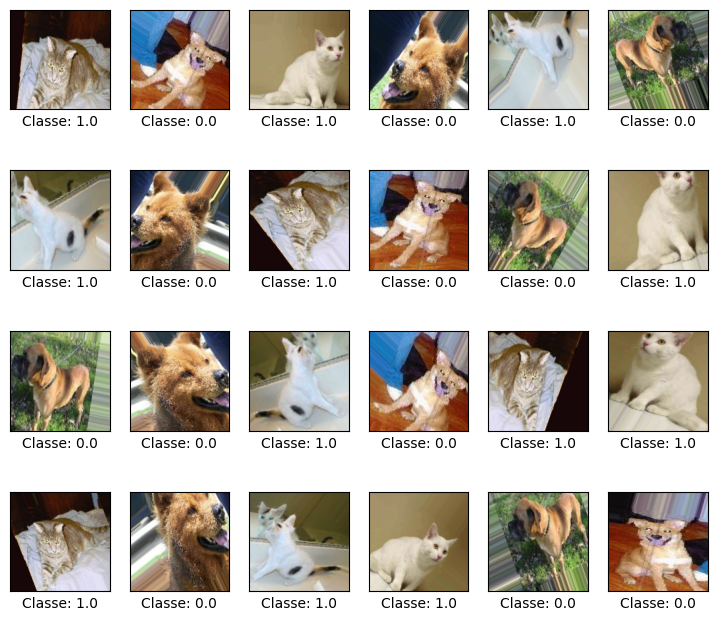

In [13]:
it_datagen = img_generator_aug.flow_from_directory(
                                                       "img_toy_test",
                                                        target_size=(150,150),
                                                        batch_size=2,
                                                        class_mode='binary',
                                                        seed=Constantes.SEED
                                                        )
plot_imgs_from_iterator(it_datagen,4,6)

## Execução e avaliação dos métodos usados

**Atividade 6 - Criação da função run_model:** Crie a função `run_model` nela, você deverá:

1. compile o modelo por meio do [método compile](https://keras.io/models/model/#compile) do objeto;
2. também no objeto do modelo, execute o método [fit_generator](https://keras.io/models/model/#fit_generator) para criar o modelo. Esse método é o que recebe como parametro o iterador que aprendemos nas seções anteriores. Não será usado neste prática, mas também existe o [método fit](https://keras.io/models/model/#fit) que recebe como parametro os atributos - neste caso seria a matriz $X$ (similar ao scikit learn).
3. Salve o modelo: A criação do modelo é uma parte custosa - em nossa prática pode durar de 15 a 30 minutos. Porém, alguns modelos poderiam demorar dias/semanas para serem criados, dependendo da profundidade e número de pesos a serem aprendidos. Por isso, é uma boa prática salvar os modelos por meio do método [save](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model). Se necessário, você pode carregar o modelo por meio da função [load_model](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model). Você pode também [salvar checkpoints do modelo](https://www.tensorflow.org/tutorials/keras/save_and_load) (opcional na prática);
4. Avalie o modelo usando validação usando o [método evaluate_generator](https://keras.io/models/sequential/#evaluate_generator) e retorne a acurácia

**Atividade 7 - Execução dos modelos**: Execute os modelos criados `model_fc`, `model_cnn` e `model_cnn_dropout` com a função run_model. Obtenha o resultado da validação. Sem GPU, a execução de cada modelo levar de 30 minutos a 4 horas. Você pode mandar executar e ir dormir :) - ou, para testar, diminua para um o número de épocas para ver funcionando mais rápido e, logo após, execute "de verdade" com os parametros padrão. Você pode também usar a GPU do [Google colab](colab.research.google.com) (https://colab.research.google.com/drive/1lxs6RC19LjWT_WvhIQ08sDac2eicjCiW?usp=sharing). Com o colab, você terá apenas um trabalho a mais para enviar o dataset ao colab.

In [7]:
from cats_vs_dogs import*
#parametros - deixar o padrao
#param_default = ParametrosRedeNeural(int_num_epochs=1)#coloque apos testar com 1, você pode um valor maoir para analisar)
param_default = ParametrosRedeNeural()

In [8]:
#sempre pegar o dataset - para reiniciar o iterator
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
#rode run_model para o fully connected model use o arr_it_gen em cada posição
#.. Constantes.IDX_TREINO e Constantes.IDX_VALIDACAO para pegar os iteradores
acc_fc = run_model(model_fc,
                   arr_it_gen[Constantes.IDX_TREINO],
                   arr_it_gen[Constantes.IDX_VALIDACAO],
                   param_default,
                   "cats_vs_dogs_fc.h5",
                   #a quantidade de passos na validação deve ser a apresentada abaixo
                   #pois precisamos de garanteir que o iterador da validação passe
                   #por todos os itens de validação
                   Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Acurácia FC: {acc_fc}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.


/content/cats_vs_dogs.py:163: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_gen_train,


Epoch 1/32
32/32 [==============================] - 9s 95ms/step - loss: 15.2693 - accuracy: 0.4961
Epoch 2/32
32/32 [==============================] - 4s 125ms/step - loss: 3.0162 - accuracy: 0.4785
Epoch 3/32
32/32 [==============================] - 3s 95ms/step - loss: 1.1443 - accuracy: 0.4854
Epoch 4/32
32/32 [==============================] - 3s 99ms/step - loss: 0.7395 - accuracy: 0.5234
Epoch 5/32
32/32 [==============================] - 3s 95ms/step - loss: 0.6942 - accuracy: 0.5273
Epoch 6/32
32/32 [==============================] - 4s 122ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 7/32
32/32 [==============================] - 3s 95ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 8/32
32/32 [==============================] - 3s 95ms/step - loss: 0.6933 - accuracy: 0.4951
Epoch 9/32
32/32 [==============================] - 4s 116ms/step - loss: 0.6934 - accuracy: 0.4971
Epoch 10/32
32/32 [==============================] - 3s 98ms/step - loss: 0.6933 - accuracy: 0.4834
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Avaliando validação....


/content/cats_vs_dogs.py:179: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(it_gen_validation,


Acurácia FC: 0.5


In [10]:
#sempre pegar o dataset - para reiniciar o iterator
model_cnn = simple_cnn_model(add_dropout=False)
param_default = ParametrosRedeNeural()
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
#rode para run_model a CNN (sem dropout)
acc_cnn = run_model(model_cnn,
                   arr_it_gen[Constantes.IDX_TREINO],
                   arr_it_gen[Constantes.IDX_VALIDACAO],
                   param_default,
                   "cats_vs_dogs_cnn.h5",
                   #a quantidade de passos na validação deve ser a apresentada abaixo
                   #pois precisamos de garanteir que o iterador da validação passe
                   #por todos os itens de validação
                   Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Acurácia CNN: {acc_cnn}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/32
32/32 [==============================] - 11s 125ms/step - loss: 0.7138 - accuracy: 0.4961
Epoch 2/32
32/32 [==============================] - 4s 115ms/step - loss: 0.6928 - accuracy: 0.5117
Epoch 3/32
32/32 [==============================] - 3s 104ms/step - loss: 0.6936 - accuracy: 0.5439
Epoch 4/32
32/32 [==============================] - 4s 108ms/step - loss: 0.6803 - accuracy: 0.5781
Epoch 5/32
32/32 [==============================] - 4s 109ms/step - loss: 0.6911 - accuracy: 0.6025
Epoch 6/32
32/32 [==============================] - 3s 105ms/step - loss: 0.6332 - accuracy: 0.6367
Epoch 7/32
32/32 [==============================] - 3s 105ms/step - loss: 0.6163 - accuracy: 0.6631
Epoch 8/32
32/32 [==============================] - 4s 129ms/step - loss: 0.6114 - accuracy: 0.6904
Epoch 9/

In [16]:
#rode run_model para a CNN (com dropout)
model_cnn_dropout = simple_cnn_model(add_dropout=True)
param_default = ParametrosRedeNeural()
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
acc_cnn_dropout = run_model(model_cnn_dropout,
                   arr_it_gen[Constantes.IDX_TREINO],
                   arr_it_gen[Constantes.IDX_VALIDACAO],
                   param_default,
                   "cats_vs_dogs_cnn_dropout.h5",
                   #a quantidade de passos na validação deve ser a apresentada abaixo
                   #pois precisamos de garanteir que o iterador da validação passe
                   #por todos os itens de validação
                   Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Acurácia CNN (Dropout): {acc_cnn_dropout}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.


/content/cats_vs_dogs.py:163: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(it_gen_train,


Epoch 1/32
32/32 [==============================] - 5s 103ms/step - loss: 0.7080 - accuracy: 0.5039
Epoch 2/32
32/32 [==============================] - 3s 105ms/step - loss: 0.6932 - accuracy: 0.5225
Epoch 3/32
32/32 [==============================] - 3s 107ms/step - loss: 0.6895 - accuracy: 0.5435
Epoch 4/32
32/32 [==============================] - 4s 126ms/step - loss: 0.6896 - accuracy: 0.5825
Epoch 5/32
32/32 [==============================] - 3s 104ms/step - loss: 0.6774 - accuracy: 0.5884
Epoch 6/32
32/32 [==============================] - 4s 124ms/step - loss: 0.6405 - accuracy: 0.6309
Epoch 7/32
32/32 [==============================] - 3s 106ms/step - loss: 0.6101 - accuracy: 0.6597
Epoch 8/32
32/32 [==============================] - 3s 105ms/step - loss: 0.5906 - accuracy: 0.6855
Epoch 9/32
32/32 [==============================] - 4s 116ms/step - loss: 0.5677 - accuracy: 0.6968
Epoch 10/32
32/32 [==============================] - 3s 105ms/step - loss: 0.5690 - accuracy: 0.7065

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Acurácia CNN (Dropout): 0.6640625


**Atividade 8 - Data Augmentation** Agora, execute o modelo `model_cnn_dropout` porém usando `data augmentation`. Para isso, use o `img_generator_aug` (criado na seção anterior) e crie o iterador que percorra o dataset treino. Use o batch size de `param_default.int_batch_size` que é o mesmo usado no treino e use `Constantes.ARR_STR_DATA_DIR[Constantes.IDX_TREINO]` para obter o diretório do treino.

In [21]:
it_gen_aug_train = img_generator_aug.flow_from_directory (
    Constantes.ARR_STR_DATA_DIR[Constantes.IDX_TREINO],
    target_size=(150, 150),
    class_mode='binary',
    batch_size=param_default.int_batch_size,
    seed=Constantes.SEED
)

Found 2048 images belonging to 2 classes.


In [22]:
model_cnn_dropout = simple_cnn_model(add_dropout=True)
param_default = ParametrosRedeNeural()
arr_it_gen = get_dataset(param_default,Constantes.ARR_STR_DATA_DIR)
acc_cnn_data_aug = run_model(model_cnn_dropout,
                   it_gen_aug_train,
                   arr_it_gen[Constantes.IDX_VALIDACAO],
                   param_default,
                   "cats_vs_dogs_cnn_data_aug.h5",
                   #a quantidade de passos na validação deve ser a apresentada abaixo
                   #pois precisamos de garanteir que o iterador da validação passe
                   #por todos os itens de validação
                   Constantes.QTD_VALIDACAO/param_default.int_batch_size)
print(f"Acurácia CNN (data augmentation): {acc_cnn_data_aug}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/32
32/32 [==============================] - 15s 409ms/step - loss: 0.7016 - accuracy: 0.5010
Epoch 2/32
32/32 [==============================] - 15s 456ms/step - loss: 0.6948 - accuracy: 0.5132
Epoch 3/32
32/32 [==============================] - 13s 417ms/step - loss: 0.6923 - accuracy: 0.5332
Epoch 4/32
32/32 [==============================] - 14s 422ms/step - loss: 0.6925 - accuracy: 0.5479
Epoch 5/32
32/32 [==============================] - 13s 420ms/step - loss: 0.6732 - accuracy: 0.6021
Epoch 6/32
32/32 [==============================] - 14s 421ms/step - loss: 0.6675 - accuracy: 0.6011
Epoch 7/32
32/32 [==============================] - 13s 415ms/step - loss: 0.6691 - accuracy: 0.6001
Epoch 8/32
32/32 [==============================] - 13s 421ms/step - loss: 0.6634 - accuracy: 0.6074
E

**Atividade 9**: Para cada modelo, apresente a acurácia no teste

In [9]:
#Modelo FC
arr_it_gen = get_dataset(param_default, Constantes.ARR_STR_DATA_DIR)
acc_fc_test = run_model(model_fc,
                        arr_it_gen[Constantes.IDX_TREINO],
                        arr_it_gen[Constantes.IDX_TESTE],
                        param_default,
                        "cats_vs_dogs_fc_teste.h5",
                        # a quantidade de passos na validação deve ser a apresentada abaixo
                        # pois precisamos de garanteir que o iterador da validação passe
                        # por todos os itens de validação
                        Constantes.QTD_TESTE/param_default.int_batch_size)
print(f"Acurácia FC teste: {acc_fc_test}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/32
32/32 [==============================] - 4s 96ms/step - loss: 0.6932 - accuracy: 0.4941
Epoch 2/32
32/32 [==============================] - 3s 97ms/step - loss: 0.6932 - accuracy: 0.4893
Epoch 3/32
32/32 [==============================] - 3s 99ms/step - loss: 0.6932 - accuracy: 0.4912
Epoch 4/32
32/32 [==============================] - 4s 124ms/step - loss: 0.6932 - accuracy: 0.4932
Epoch 5/32
32/32 [==============================] - 3s 100ms/step - loss: 0.6932 - accuracy: 0.4932
Epoch 6/32
32/32 [==============================] - 4s 109ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/32
32/32 [==============================] - 3s 95ms/step - loss: 0.6932 - accuracy: 0.4854
Epoch 8/32
32/32 [==============================] - 3s 97ms/step - loss: 0.6932 - accuracy: 0.4893
Epoch 9/32
32/

In [11]:
#Modelo CNN_SIMPLE
arr_it_gen = get_dataset(param_default, Constantes.ARR_STR_DATA_DIR)
acc_cnn_test = run_model(model_cnn,
                         arr_it_gen[Constantes.IDX_TREINO],
                         arr_it_gen[Constantes.IDX_TESTE],
                         param_default,
                         "cats_vs_dogs_cnn_teste.h5",
                         # a quantidade de passos na validação deve ser a apresentada abaixo
                         # pois precisamos de garanteir que o iterador da validação passe
                         # por todos os itens de validação
                         Constantes.QTD_TESTE/param_default.int_batch_size)
print(f"Acurácia CNN teste: {acc_cnn_test}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/32
32/32 [==============================] - 5s 141ms/step - loss: 6.9131e-04 - accuracy: 1.0000
Epoch 2/32
32/32 [==============================] - 4s 119ms/step - loss: 0.1426 - accuracy: 0.9683
Epoch 3/32
32/32 [==============================] - 4s 112ms/step - loss: 0.0051 - accuracy: 0.9995
Epoch 4/32
32/32 [==============================] - 3s 105ms/step - loss: 6.6846e-04 - accuracy: 1.0000
Epoch 5/32
32/32 [==============================] - 4s 125ms/step - loss: 1.7826e-04 - accuracy: 1.0000
Epoch 6/32
32/32 [==============================] - 4s 108ms/step - loss: 0.3577 - accuracy: 0.9395
Epoch 7/32
32/32 [==============================] - 3s 106ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 8/32
32/32 [==============================] - 4s 130ms/step - loss: 4.5974e-04 - accuracy: 

In [17]:
#Modelo CNN_DROPOUT
arr_it_gen = get_dataset(param_default, Constantes.ARR_STR_DATA_DIR)
acc_cnn_dropout_test = run_model(model_cnn_dropout,
                                 arr_it_gen[Constantes.IDX_TREINO],
                                 arr_it_gen[Constantes.IDX_TESTE],
                                 param_default,
                                 "cats_vs_dogs_cnn_dropout_teste.h5",
                                 # a quantidade de passos na validação deve ser a apresentada abaixo
                                 # pois precisamos de garanteir que o iterador da validação passe
                                 # por todos os itens de validação
                                 Constantes.QTD_TESTE/param_default.int_batch_size)
print(f"Acurácia CNN (Dropout) teste: {acc_cnn_dropout_test}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/32
32/32 [==============================] - 4s 108ms/step - loss: 0.0816 - accuracy: 0.9731
Epoch 2/32
32/32 [==============================] - 3s 102ms/step - loss: 0.0833 - accuracy: 0.9717
Epoch 3/32
32/32 [==============================] - 4s 130ms/step - loss: 0.0553 - accuracy: 0.9800
Epoch 4/32
32/32 [==============================] - 3s 105ms/step - loss: 0.0838 - accuracy: 0.9712
Epoch 5/32
32/32 [==============================] - 3s 104ms/step - loss: 0.1215 - accuracy: 0.9590
Epoch 6/32
32/32 [==============================] - 4s 129ms/step - loss: 0.0465 - accuracy: 0.9849
Epoch 7/32
32/32 [==============================] - 3s 105ms/step - loss: 0.0776 - accuracy: 0.9697
Epoch 8/32
32/32 [==============================] - 3s 104ms/step - loss: 0.0306 - accuracy: 0.9897
Epoch 9/3

In [24]:
#MODELO CNN_DATA_AUG
arr_it_gen = get_dataset(param_default, Constantes.ARR_STR_DATA_DIR)
acc_cnn_data_aug_test = run_model(model_cnn_dropout,
                                  it_gen_aug_train,
                                  arr_it_gen[Constantes.IDX_TESTE],
                                  param_default,
                                  "cats_vs_dogs_cnn_dropout_aug_teste.h5",
                                  # a quantidade de passos na validação deve ser a apresentada abaixo
                                  # pois precisamos de garanteir que o iterador da validação passe
                                  # por todos os itens de validação
                                  Constantes.QTD_TESTE/param_default.int_batch_size)
print(f"Acurácia CNN (data augmentation) teste: {acc_cnn_data_aug_test}")

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Avaliando validação....
Acurácia CNN (data augmentation) teste: 0.779296875


**Atividade 9 - Análise** Descreva abaixo suas conclusões: existe algum modelo que gera overfitting? E underfitting, lembrando que o estado da arte gera resultados acima de 90% de acurácia? Qual é o impacto do _dropout_ e do uso de _Data augmentation_ no modelo?



O restante desta prática é opcional, se divirta! :)

**\[Opcional 1\]** Use outras técnicas para prevenir overfitting e analise também o resultado.

**[Opcional 2]** Use o predict_generator e analise, na partição de validação, quando o melhor modelo erra. Discuta e gere um plot de algumas imagens com os erros de classificação.

**[Opcional 3]** Usando a melhor arquitetura, varie os parametros na validação, encontre o melhor resultado e execute o teste.

**\[Opcional 4\]** Use o [tensor board](https://www.tensorflow.org/tensorboard/get_started) para fazer uma análise mais aprofundada do resultado. Apresente os gráficos e uma discussão dos resultados abaixo. O TensorFlow é usado pelo Keras. Você verá que ele cria o modelo de outra forma. Nós usamos a functional API, ela é mais flexivel que a [Sequetial API](http://keras.io/models/sequential/) do keras.

**[Opcional 5]** Faça transfer learning usando a arquitetura VGG (veja instruções abaixo). Pode demorar bastante em uma máquina sem GPU. Usar o [colab](https://colab.research.google.com) pode ser uma boa - coloque o link aqui.

## Transfer Learning

Como dito em sala, o TransferLearning é uma técnica em que é possível extrair camadas de uma rede neural prétreinada e, com ela, usar em outro dominio. Isso é muito interessante pois, pode-se demorar horas/dias para se treinar uma rede neural e precisa-se de muitas instancias.

Caso tenhamos uma rede que já foi treinada com milhares/milhões de instancias rotuladas, se deixaramos os pesos "congelados" de algumas camadas, adiantamos o processo de otimização e, assim, conseguimos uma melhor performance. Chollet F. (2017) conseguiu com uma metodologia parecida com essa da prática, um dataset de mesmo tamanho e tranfer learning uma acurácia acima de 90%. Algumas regras importantes também segundo Chollet F., (2017):  

- Em uma CNN, temos geralmente no final camadas FC. Não é recomendável congelar camadas FC, pois, tais camadas não constumam generalizar tanto quanto as camadas Convolucionais;

- Quanto mais próximo nossas instancias são das instancias da rede pretreinada, mais camadas podemos congelar. Por exemplo, a VGG16 treinado com o [ImageNet](http://image-net.org/explore) possui 1000 classes, inclusive, animais. Assim, para nosso problema de classificar cães e gatos, como é proximo desse problema, podemos congelar bastante camadas. Por exemplo, podemos até deixar descongelada apenas a camada de saída.

O exemplo baixo possui o modelo com a arquitetura VGG16 treinada com o dataset ImageNet e uma função para congelar até uma determinada camada. O parametro `include_top=False` faz com que só usarmos a parte convolucional (sem as FC) desta arquitetura. Temos que criar a parte de FC para ser treinada.

Caso opte por descongelar algumas camadas da VGG16 (e não apenas incrementar) faça da seguinte forma:

- Mantenha todas as camadas da VGG16 congeladas, adicione as camadas FC (ou CONV) que você deseja e realize o treinamento;
- Descongele as camadas da VGG16 desejadas;
- Volte a treinar o modelo.

O nome dessa técnica também é chamada de *fine tunning*.

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

conv_base.summary()
#conv_base.get_layer("block5_pool").output.shape

In [ ]:
def freeze_first_layers(model,last_freezed_layer_name):
    for layer in model.layers:
        layer.trainable = False
        if layer.name == last_freezed_layer_name:
            break
    return model

def fine_tune_model(conv_base_model):
    last_layer = len(conv_base_model.layers)-1

    achatar = layers.Flatten()(conv_base_model.layers[last_layer].output)
    fc = layers.Dense(300,activation="relu",name="Camada2")(achatar)
    saida = layers.Dense(1,activation="sigmoid", name="saida")(fc)

    return Model(inputs=conv_base_model.input, outputs=saida)



Outra utilidade de modelos pretreinados é fazer a extração de atributos, ou seja, representar imagens com uma matriz/vetor de uma camada intermediária de algum modelo pretreinado. Veja um código que extrai os atributos das imagens:

In [ ]:
import numpy as np
def extract_features(model,layer_name,data_generator,batch_size, sample_size):
    """
    Extrai a saída da camada layer_name para representar as features de
    cada instancia

    Adaptado de: https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    e do livro "Deep Learning with Python" (François Chollet, 2018)
    """
    #obtem o modelo da primeiras camadas do model (até a layer_name)
    output_layer = model.get_layer(layer_name).output
    model_base = Model(inputs=model.input,
                                     outputs=output_layer)
    #inicializa o vetor de features com a mesma dimensão da ultima camada
    last_layer_shape = output_layer.shape.as_list()
    last_layer_shape[0] = batch_size
    features = np.zeros(last_layer_shape)

    #inicializa o vetor de labels com o mesmo tamanho da amostra
    labels = np.zeros(sample_size)
    i = 0
    for inputs_batch, labels in data_generator:
        print(f"Gerando features mini-batch #{i}...")
        #obtem as features
        features_batch = model_base.predict(inputs_batch)

        #adiciona as features no batach
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels

        i += 1
        print(i)
        #termina assim que atingir o tamanho da amostra
        if (i*batch_size)>=sample_size:
            break
    return labels,features

# Bibliografia

- McReynolds, Tom, and David Blythe. **[Advanced graphics programming using OpenGL](https://www.sciencedirect.com/science/article/pii/B9781558606593500147#cesec16). Cap. 14.** Elsevier, 2005.
- Chollet , François. **Deep Learning with Python**. Manning Publications, 2017
- Andrew D.G.. **[Especialização Deep Learning](https://www.coursera.org/specializations/deep-learning), curso Convolutional Neural Networks (semana 1 e 2)**. Coursera. 2019


In [ ]:
it_datagen=get_dataset(ParametrosRedeNeural(),['data/treino','data/validacao','data/teste'])
plot_imgs_from_iterator(it_datagen[0],2,6)
plot_imgs_from_iterator(it_datagen[1],2,6)
plot_imgs_from_iterator(it_datagen[2],2,6)